# Statistics and Visualisations
_Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science._
* Supervisor: Wolfgang Aussenegg
* Co-Supervisor: Sascha Hunold

Purpose of this notebook is to calculate the statistics needed, in order to answer our hypotheses in the reports

In [21]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

In [22]:
import pickle
from scipy.stats import ttest_ind
import pandas as pd
from eventstudystatistics import grank, adjBMP
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.stats as stats
from tools import display_table
# set logging to warning
import logging
logging.getLogger().setLevel(logging.WARNING)
# unpickle the abnormal returns
df_abnormal_returns = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

EVENT_INDEX = 0

investigation_periods = settings["investigation_periods"]

day_labels = np.asarray(list(range(settings["L2"]))) - (settings["L2"]-1)/2

CAR_repr = lambda x: str([x[0]-(settings["L2"]-1)/2, x[1]-(settings["L2"]-1)/2])
CAR_periods = settings["CAR_periods"]
event_day = settings["event_day"]

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "rb") as f:
    companies = pickle.load(f)


### Having a look at all trade types together

In [23]:
types_of_interest = settings["types_of_interest"]
counts = df_abnormal_returns.groupby(level=2).count()[0].rename({0: "N"})
print(f"relevant filings: ",counts[types_of_interest].sum())
print(counts[types_of_interest])
print(f"dropped filings ", counts.sum() - counts[types_of_interest].sum())

relevant filings:  69212
TradeType
P - Purchase    16554
S - Sale        30438
S - Sale+OE     22220
Name: 0, dtype: int64
dropped filings  0


In [24]:
# enable multiindex slicing
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)

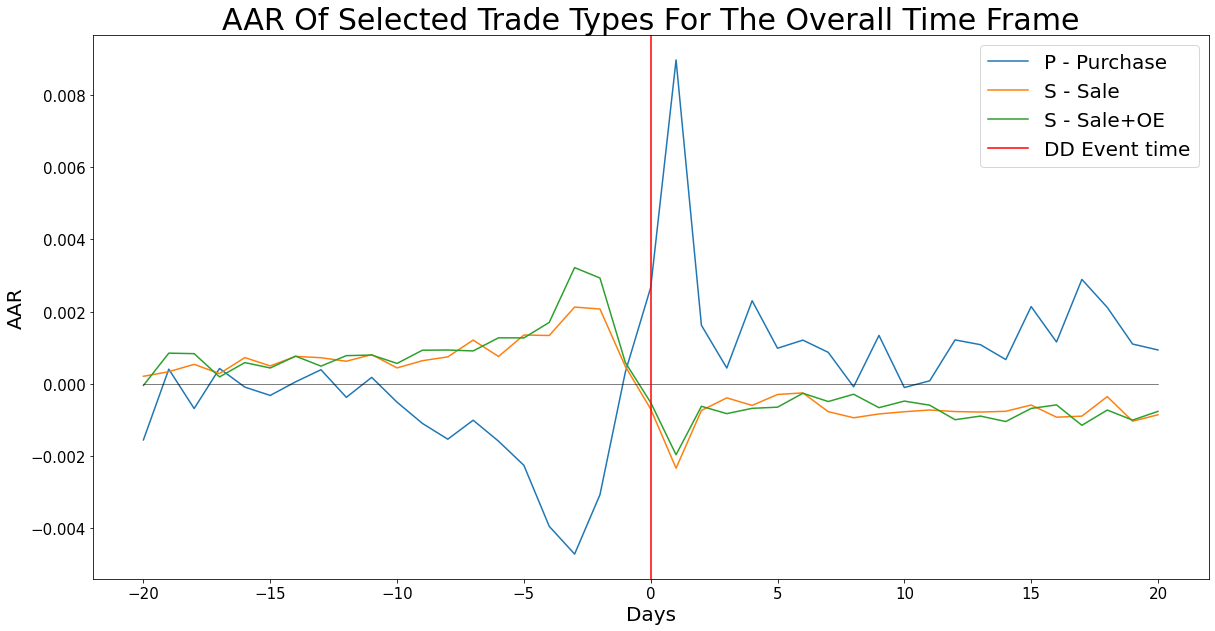

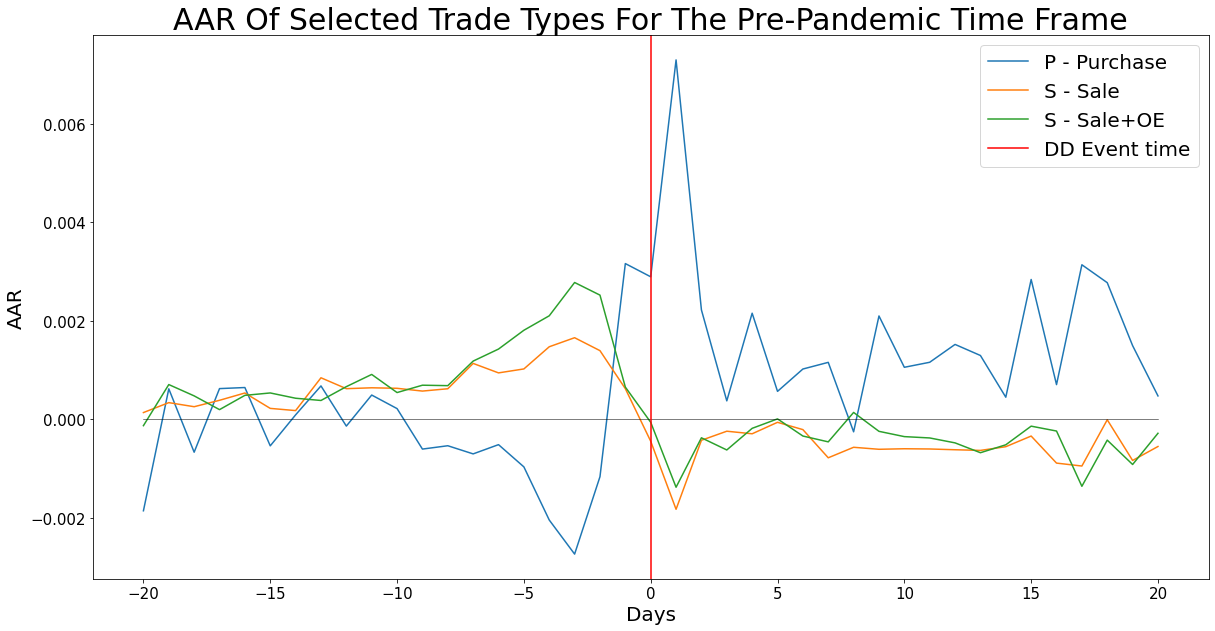

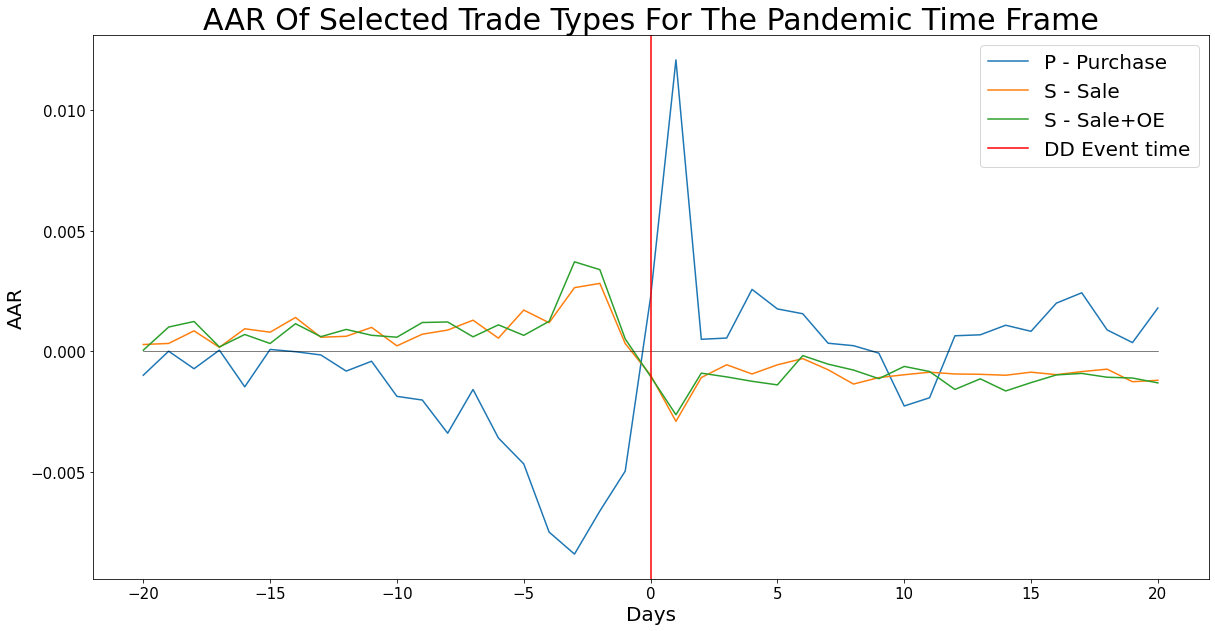

In [25]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).mean().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"AAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)

    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("AAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/AAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

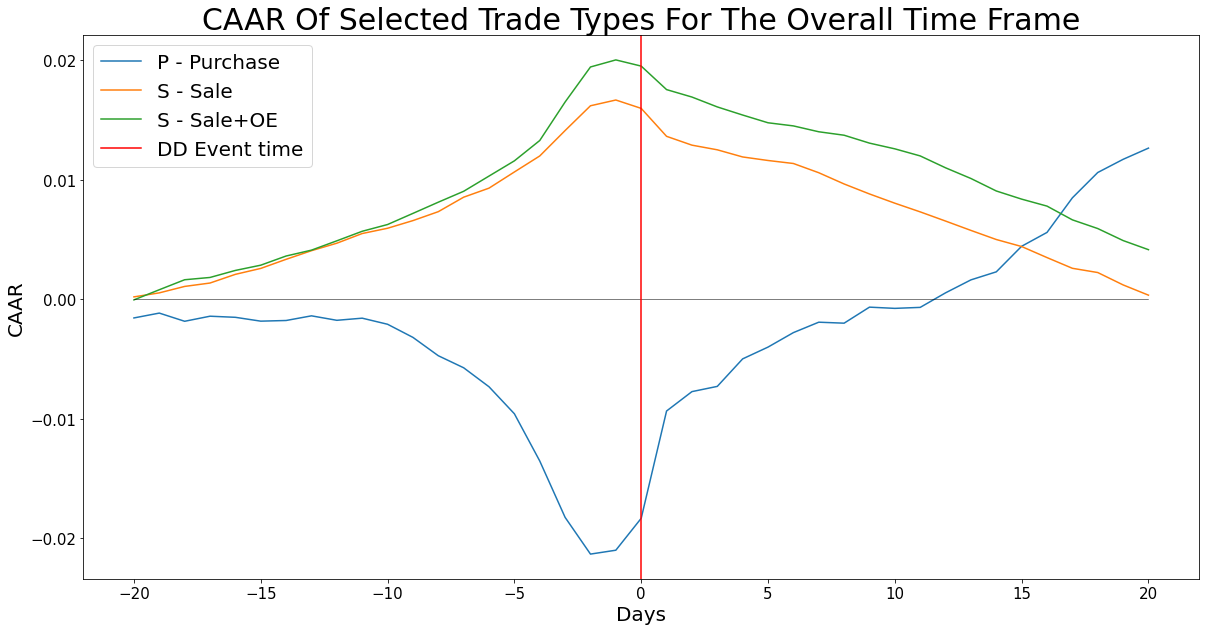

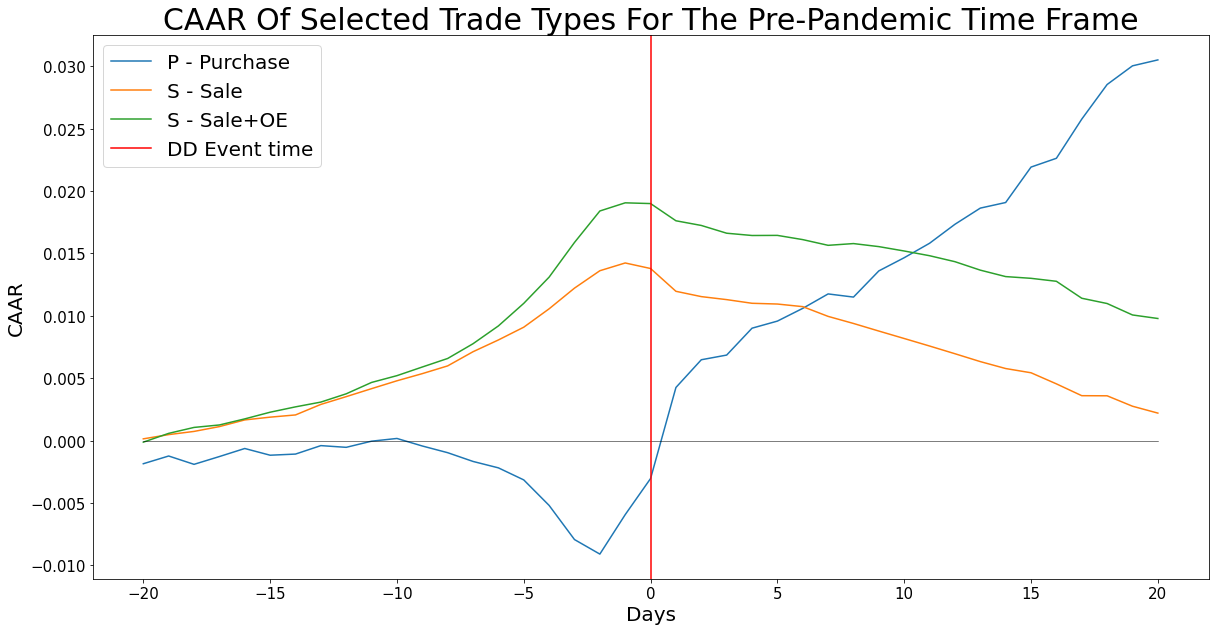

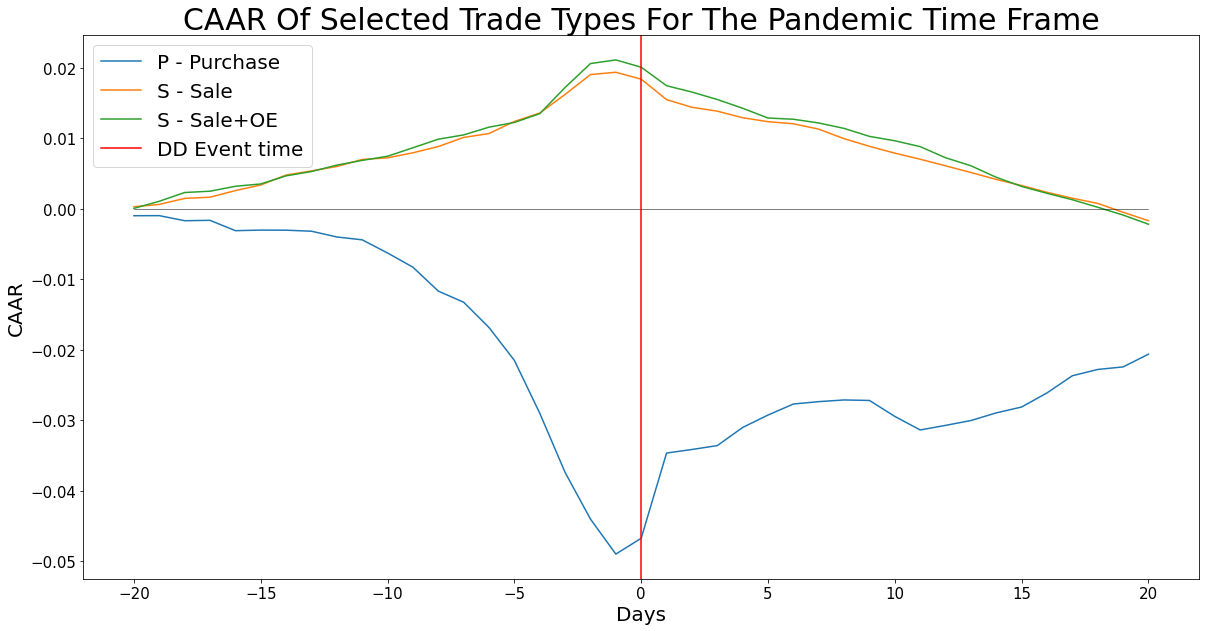

In [26]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].cumsum(axis=1).groupby(level=[2]).mean().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"CAAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("CAAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CAAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

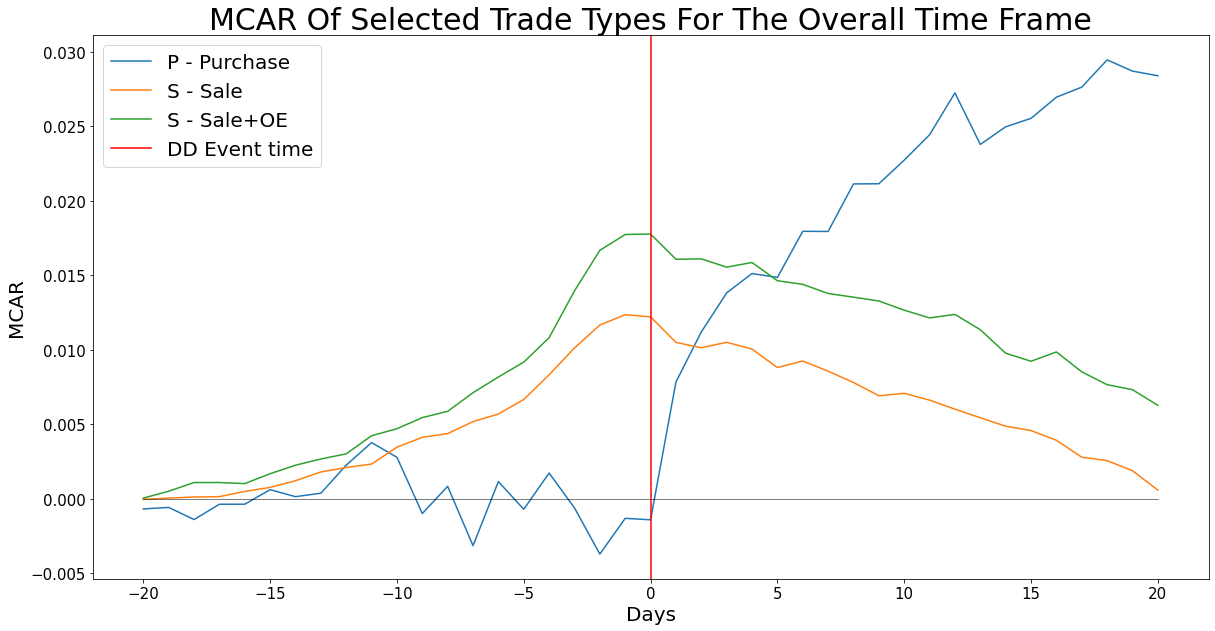

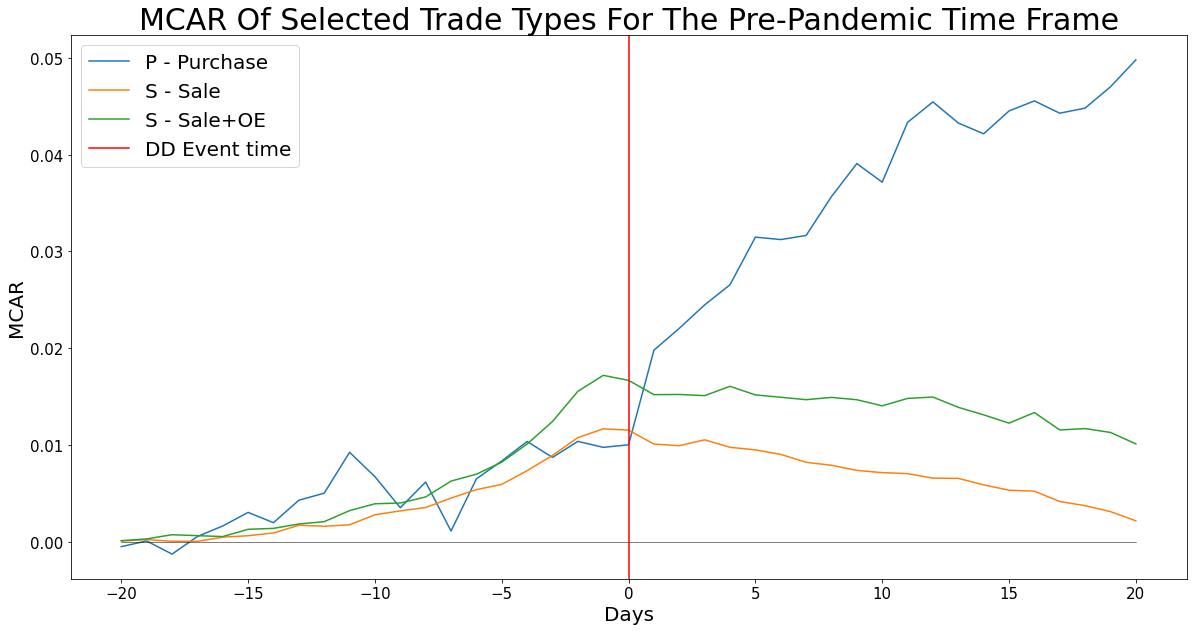

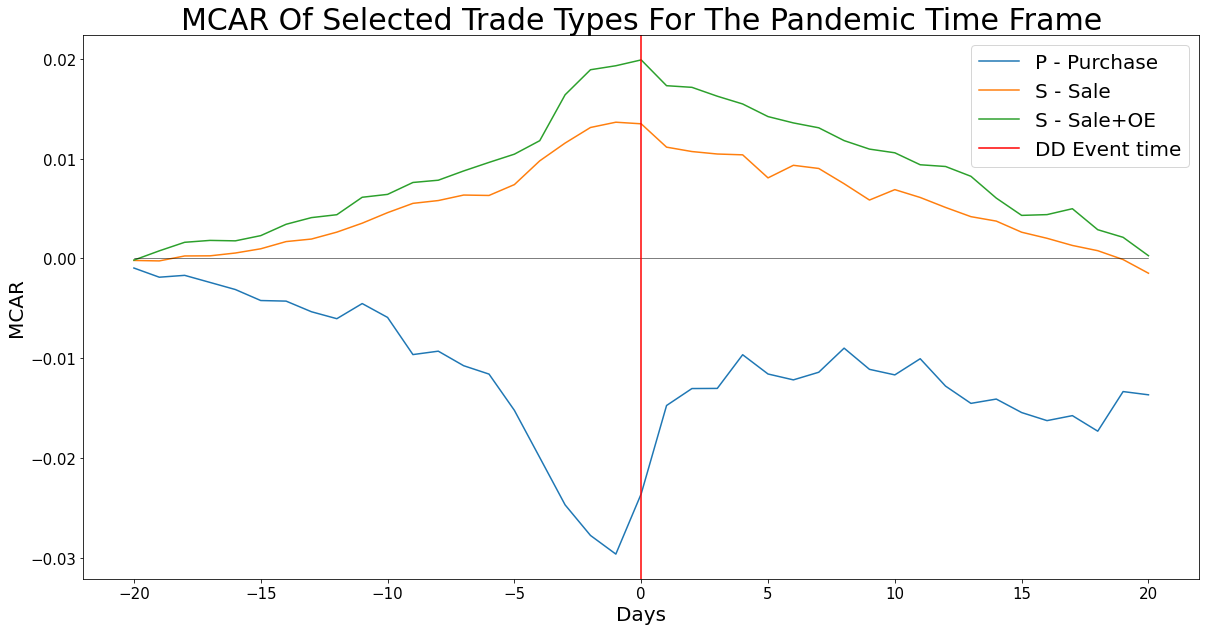

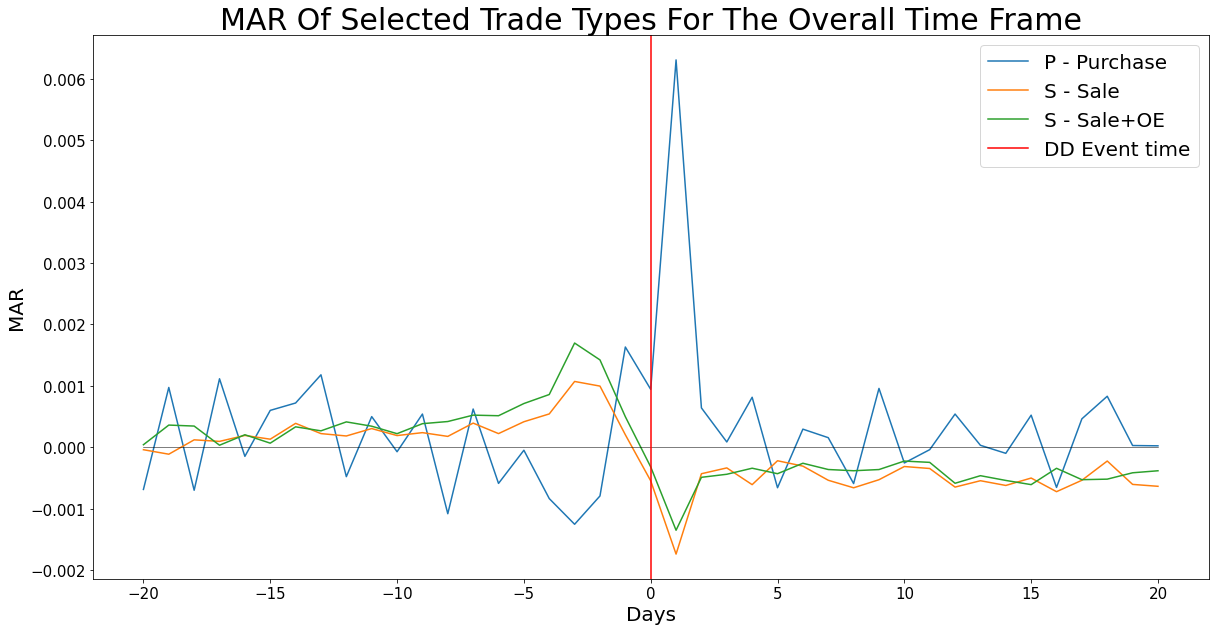

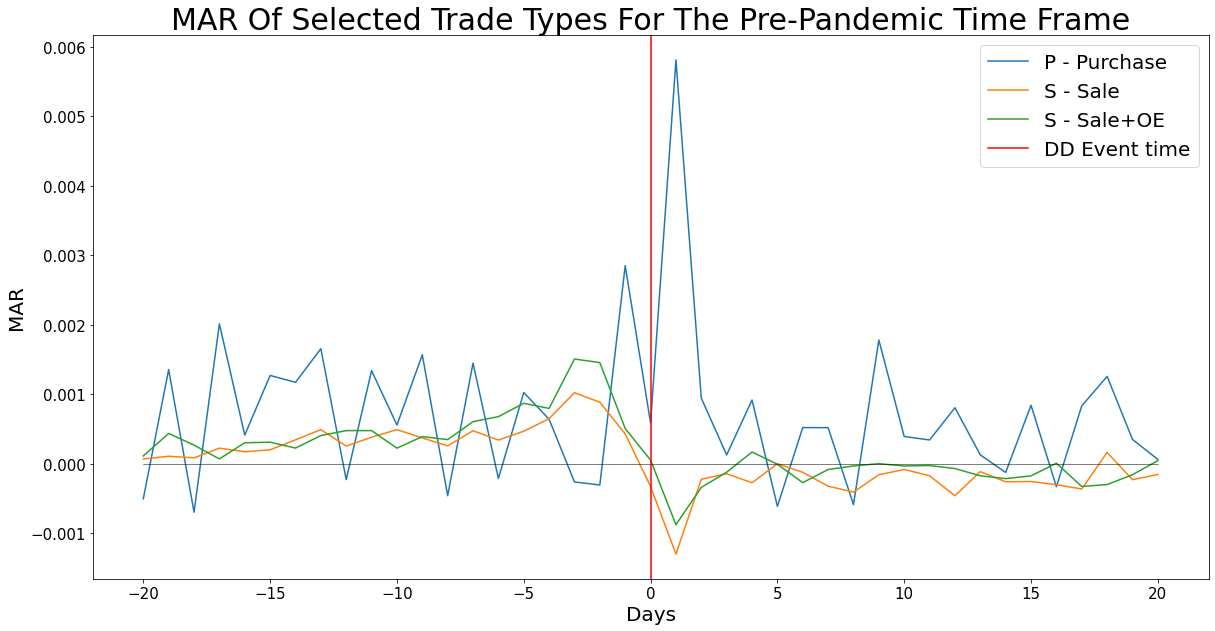

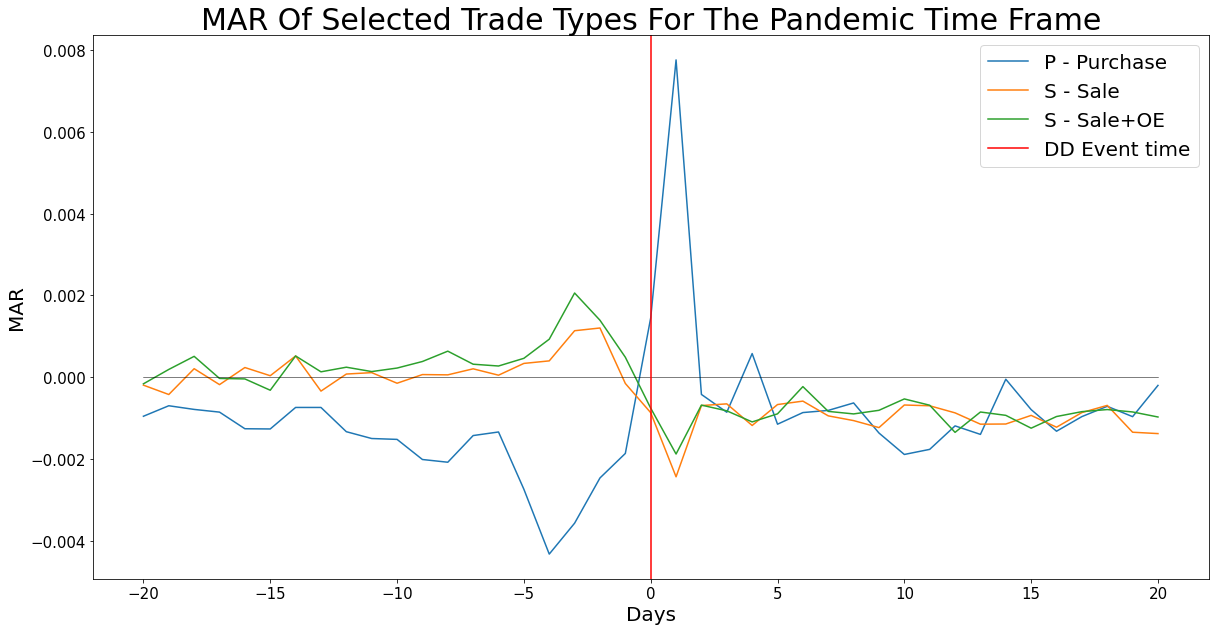

In [27]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].cumsum(axis=1).groupby(level=[2]).median().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MCAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MCAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CMAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).median().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/MAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

In [28]:
df_abnormal_returns

0         1         2   \
Company i   TradeType    event_timestamp                                 
A       0   S - Sale     2021-12-30      -0.012152  0.007386 -0.007207   
        1   S - Sale     2021-12-21      -0.009360 -0.052116 -0.013611   
        2   S - Sale     2021-12-17       0.005563  0.017338 -0.009051   
        3   S - Sale     2021-12-06      -0.010824  0.026151 -0.007095   
        4   S - Sale     2021-12-02      -0.001448 -0.003188 -0.010929   
...                                            ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04      -0.015043 -0.005062  0.001130   
        103 S - Sale+OE  2018-12-03       0.013954  0.001616 -0.004790   
        104 S - Sale+OE  2018-11-08       0.000365 -0.038445  0.016064   
        105 S - Sale+OE  2018-11-06      -0.026091 -0.022854 -0.005093   
        106 P - Purchase 2018-11-02       0.002474 -0.005742 -0.025981   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
A       0   S - Sale     2021-12-30       0.006358  0.006979  0.014670   
        1   S - Sale     2021-12-21       0.006317  0.005939 -0.005570   
        2   S - Sale     2021-12-17      -0.051981 -0.013412  0.007379   
        3   S - Sale     2021-12-06      -0.001398 -0.004678  0.010050   
        4   S - Sale     2021-12-02       0.026045 -0.007215 -0.001528   
...                                            ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04       0.024848  0.007290 -0.010050   
        103 S - Sale+OE  2018-12-03      -0.006538  0.003777 -0.002015   
        104 S - Sale+OE  2018-11-08       0.003199 -0.026818 -0.019334   
        105 S - Sale+OE  2018-11-06      -0.037437  0.015178  0.006532   
        106 P - Purchase 2018-11-02      -0.022245 -0.004582 -0.037544   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
A       0   S - Sale     2021-12-30      -0.007495  0.008109  0.004208   
        1   S - Sale     2021-12-21      -0.012643  0.006108 -0.007784   
        2   S - Sale     2021-12-17       0.006076 -0.004588 -0.012010   
        3   S - Sale     2021-12-06      -0.019655  0.021602  0.003414   
        4   S - Sale     2021-12-02      -0.004790  0.009945 -0.019773   
...                                            ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04      -0.015858 -0.007550 -0.004943   
        103 S - Sale+OE  2018-12-03       0.009663 -0.009294 -0.001172   
        104 S - Sale+OE  2018-11-08      -0.023704  0.019170 -0.027925   
        105 S - Sale+OE  2018-11-06      -0.028037 -0.022931 -0.024132   
        106 P - Purchase 2018-11-02       0.015252  0.006202 -0.027930   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
A       0   S - Sale     2021-12-30      -0.026409  ... -0.002370 -0.021205   
        1   S - Sale     2021-12-21       0.005237  ...  0.001087 -0.028015   
        2   S - Sale     2021-12-17       0.005649  ... -0.038211 -0.010414   
        3   S - Sale     2021-12-06       0.005254  ...  0.013336  0.013480   
        4   S - Sale     2021-12-02       0.021489  ...  0.008707 -0.000537   
...                                            ...  ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04       0.004333  ...  0.003047 -0.003422   
        103 S - Sale+OE  2018-12-03       0.023488  ...  0.006629 -0.000657   
        104 S - Sale+OE  2018-11-08      -0.010011  ... -0.013939 -0.015307   
        105 S - Sale+OE  2018-11-06       0.017048  ... -0.000491 -0.006011   
        106 P - Purchase 2018-11-02      -0.022597  ... -0.018943  0.002923   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

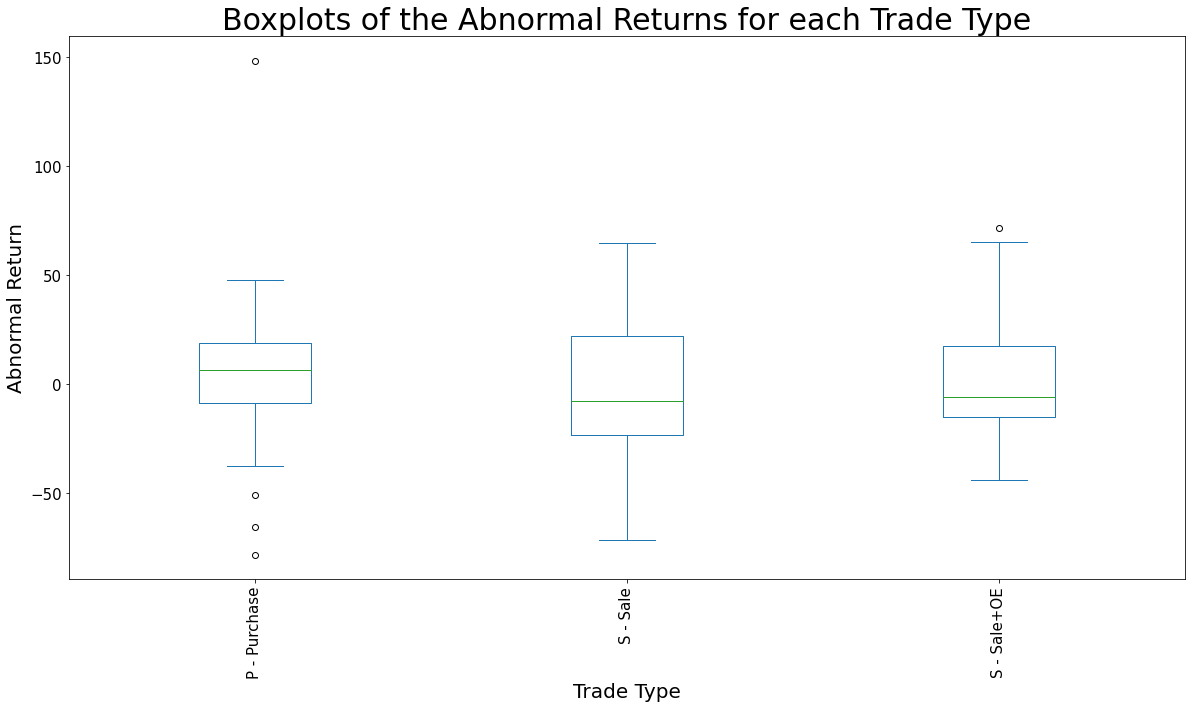

In [29]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().set_index(day_labels).plot.box(rot=90, figsize=(fig_height, 10))
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=title_size)
ax.set_xlabel("Trade Type", fontsize=label_size)
ax.set_ylabel("Abnormal Return", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.svg", dpi=600, bbox_inches='tight')

In [30]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['P - Purchase', 'S - Sale+OE', 'S - Sale']

Specify the type of the trades to investigate

In [31]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [32]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
AA      9   2021-01-28      -0.009691  0.026533 -0.004668  0.028584 -0.007647   
        11  2020-11-18       0.048303  0.005339 -0.024841  0.009477  0.021854   
        12  2020-10-20      -0.017871  0.000492  0.001662 -0.040046  0.018044   
        13  2020-09-18      -0.005682 -0.043191  0.006080 -0.013762 -0.009739   
        14  2020-08-18       0.018392 -0.015857 -0.021402  0.008227  0.025276   
...                               ...       ...       ...       ...       ...   
ZBH     28  2018-02-20       0.018379 -0.013861  0.002480 -0.002727  0.006863   
ZOES    0   2018-02-26      -0.048935  0.019884  0.025254  0.009822 -0.018575   
ZTS     25  2021-02-23      -0.011247 -0.007338 -0.027405  0.015873 -0.004572   
ZWS     102 2019-02-04      -0.015043 -0.005062  0.001130  0.024848  0.007290   
        106 2018-11-02       0.002474 -0.005742 -0.025981 -0.022245 -0.004582   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
AA      9   2021-01-28       0.026128 -0.021591 -0.016989 -0.014880  0.009034   
        11  2020-11-18       0.019131  0.013988  0.024911  0.009131 -0.024158   
        12  2020-10-20      -0.033954 -0.025941 -0.028134  0.031012 -0.033492   
        13  2020-09-18      -0.024002 -0.001233 -0.019893  0.017335 -0.056728   
        14  2020-08-18      -0.018055 -0.003332  0.015975 -0.006281  0.041729   
...                               ...       ...       ...       ...       ...   
ZBH     28  2018-02-20       0.013145 -0.006016  0.009341  0.007475 -0.007558   
ZOES    0   2018-02-26      -0.019655  0.030259 -0.024981  0.013671  0.020778   
ZTS     25  2021-02-23       0.001823  0.005879 -0.015824  0.007827  0.010797   
ZWS     102 2019-02-04      -0.010050 -0.015858 -0.007550 -0.004943  0.004333   
        106 2018-11-02      -0.037544  0.015252  0.006202 -0.027930 -0.022597   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
AA      9   2021-01-28       ...  0.000560  0.026017 -0.021297 -0.023540   
        11  2020-11-18       ...  0.042893 -0.005761 -0.013322 -0.021939   
        12  2020-10-20       ... -0.068731  0.018846  0.021893  0.010325   
        13  2020-09-18       ... -0.025759 -0.009993  0.013452  0.012795   
        14  2020-08-18       ... -0.049346  0.006079  0.016930  0.015471   
...                          ...       ...       ...       ...       ...   
ZBH     28  2018-02-20       ...  0.024852 -0.008583 -0.001994 -0.021000   
ZOES    0   2018-02-26       ... -0.011360 -0.017090 -0.001519 -0.010115   
ZTS     25  2021-02-23       ...  0.001747  0.004471 -0.000592  0.013253   
ZWS     102 2019-02-04       ...  0.003047 -0.003422 -0.004152 -0.005546   
        106 2018-11-02       ... -0.018943  0.002923 -0.000575 -0.005807   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
AA      9   2021-01-28       0.083143  0.073253 -0.000379  0.065464 -0.016858   
        11  2020-11-18       0.052514 -0.043924 -0.026661 -0.012799 -0.029024   
        12  2020-10-20      -0.004100 -0.011539  0.012518  0.018643  0.022395   
        13  2020-09-18      -0.030474 -0.009488  0.021591  0.027040 -0.057837   
        14  2020-08-18      -0.035472 -0.001631  0.004840 -0.016912 -0.024745   
...                               ...       ...       ...       ...       ...   
ZBH     28  2018-02-20      -0.000527 -0.011909 -0.002330  0.005873 -0.012736   
ZOES    0   2018-02-26       0.012628  0.020007 -0.014061 -0.001158  0.006081   
ZTS     25  2021-02-23       0.005104  0.005643 -0.018974  0.005845  0.017138   
ZWS     102 2019-02-04      -0.014531 -0.003519

In [33]:
df_abnormal_returns.loc[:,:, types_of_interest].groupby(level=[2]).count()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TradeType,,,,,,,,,,,,,,,,,,,,,
P - Purchase,16554,16554,16554,16554,16554,16554,16554,16554,16554,16554,...,16554,16554,16554,16554,16554,16554,16554,16554,16554,16554
S - Sale,30438,30438,30438,30438,30438,30438,30438,30438,30438,30438,...,30438,30438,30438,30438,30438,30438,30438,30438,30438,30438
S - Sale+OE,22220,22220,22220,22220,22220,22220,22220,22220,22220,22220,...,22220,22220,22220,22220,22220,22220,22220,22220,22220,22220


In [34]:
CAR = df_abnormal_returns.cumsum(axis =1).loc[:,:, types_of_interest]
CAR

0         1         2   \
Company i   TradeType    event_timestamp                                 
A       0   S - Sale     2021-12-30      -0.012152 -0.004767 -0.011974   
        1   S - Sale     2021-12-21      -0.009360 -0.061475 -0.075087   
        2   S - Sale     2021-12-17       0.005563  0.022901  0.013850   
        3   S - Sale     2021-12-06      -0.010824  0.015327  0.008232   
        4   S - Sale     2021-12-02      -0.001448 -0.004636 -0.015566   
...                                            ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04      -0.015043 -0.020104 -0.018974   
        103 S - Sale+OE  2018-12-03       0.013954  0.015571  0.010781   
        104 S - Sale+OE  2018-11-08       0.000365 -0.038081 -0.022016   
        105 S - Sale+OE  2018-11-06      -0.026091 -0.048945 -0.054039   
        106 P - Purchase 2018-11-02       0.002474 -0.003268 -0.029249   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
A       0   S - Sale     2021-12-30      -0.005616  0.001363  0.016032   
        1   S - Sale     2021-12-21      -0.068770 -0.062831 -0.068400   
        2   S - Sale     2021-12-17      -0.038131 -0.051543 -0.044164   
        3   S - Sale     2021-12-06       0.006834  0.002155  0.012205   
        4   S - Sale     2021-12-02       0.010480  0.003265  0.001737   
...                                            ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04       0.005874  0.013165  0.003114   
        103 S - Sale+OE  2018-12-03       0.004243  0.008020  0.006005   
        104 S - Sale+OE  2018-11-08      -0.018817 -0.045635 -0.064969   
        105 S - Sale+OE  2018-11-06      -0.091476 -0.076298 -0.069766   
        106 P - Purchase 2018-11-02      -0.051494 -0.056076 -0.093620   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
A       0   S - Sale     2021-12-30       0.008537  0.016646  0.020854   
        1   S - Sale     2021-12-21      -0.081044 -0.074936 -0.082720   
        2   S - Sale     2021-12-17      -0.038088 -0.042676 -0.054687   
        3   S - Sale     2021-12-06      -0.007450  0.014152  0.017567   
        4   S - Sale     2021-12-02      -0.003054  0.006891 -0.012882   
...                                            ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04      -0.012744 -0.020295 -0.025237   
        103 S - Sale+OE  2018-12-03       0.015668  0.006374  0.005202   
        104 S - Sale+OE  2018-11-08      -0.088673 -0.069503 -0.097428   
        105 S - Sale+OE  2018-11-06      -0.097803 -0.120733 -0.144865   
        106 P - Purchase 2018-11-02      -0.078367 -0.072165 -0.100095   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
A       0   S - Sale     2021-12-30      -0.005555  ... -0.072703 -0.093908   
        1   S - Sale     2021-12-21      -0.077483  ... -0.129670 -0.157685   
        2   S - Sale     2021-12-17      -0.049038  ... -0.089872 -0.100287   
        3   S - Sale     2021-12-06       0.022821  ... -0.032094 -0.018614   
        4   S - Sale     2021-12-02       0.008606  ... -0.053240 -0.053777   
...                                            ...  ...       ...       ...   
ZWS     102 P - Purchase 2019-02-04      -0.020904  ...  0.016494  0.013071   
        103 S - Sale+OE  2018-12-03       0.028690  ... -0.014193 -0.014850   
        104 S - Sale+OE  2018-11-08      -0.107439  ...  0.014478 -0.000829   
        105 S - Sale+OE  2018-11-06      -0.127817  ... -0.044125 -0.050136   
        106 P - Purchase 2018-11-02      -0.122692  ... -0.046718 -0.043795   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

In [35]:
CAR[CAR.isnull().any(axis=1)]

,,,,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Company,i,TradeType,event_timestamp,,,,,,,,,,,,,,,,,,,,,


In [36]:
# Temp fix to make the rest work
##CAR = CAR[CAR.isnull().any(axis=1) == False]
##CAR
df_abnormal_returns[df_abnormal_returns.isnull().any(axis=1)]

,,,,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Company,i,TradeType,event_timestamp,,,,,,,,,,,,,,,,,,,,,


In [37]:
# aggregate on time axis
CAAR = CAR.groupby(level=[2]).mean().transpose()
print(display_table(CAAR.describe().reset_index()))

\begin{table}[H]
\centering
\caption{Summary of discarded input}
\label{table:excluded_companies}
\begin{tabular}{lSSS}
\toprule
{\bfseries index} & {\bfseries P - Purchase} & {\bfseries S - Sale} & {S - Sale+OE} \\
\midrule
count & 41.000000 & 41.000000 & 41.000000 \\
mean & -0.003042 & 0.007289 & 0.009703 \\
std & 0.007751 & 0.004805 & 0.005636 \\
min & -0.021306 & 0.000208 & -0.000044 \\
25% & -0.005722 & 0.003350 & 0.004919 \\
50% & -0.001822 & 0.006589 & 0.009066 \\
75% & -0.000670 & 0.011365 & 0.014019 \\
\bfseries max & \bfseries 0.012651 & \bfseries 0.016675 & \bfseries 0.020029 \\
\bottomrule
\end{tabular}
\end{table}



In [38]:
# aggregate on filings axis
results = []
index_stats = []
for type_ in types_of_interest:
    for ip in investigation_periods:
        for cp in CAR_periods:
            l, r = investigation_periods[ip]
            l_CAR, r_CAR = CAR_periods[cp]
            CAR = df_abnormal_returns.iloc[:,l_CAR:(r_CAR+1)].sum(axis =1).loc[:,:, types_of_interest]
            res = CAR.loc[:,:,type_,l:r].groupby(level=[2]).describe().transpose()
            res = res.round(4)
            res.loc["count"] = res.loc["count"].astype(int).astype(str)
            results.append(res.transpose())
            index_stats.append((type_, ip, cp))

In [39]:
stats_df = pd.concat(results)
stats_df.index = pd.MultiIndex.from_tuples(index_stats, names=["Trade Type", "Investigation Period", "CAR period"])
print(display_table(stats_df))

\begin{table}
\centering
\caption{Summary of discarded input}
\label{table:excluded_companies}
\begin{tabular}{lllllllllll}
\toprule
            &          &        &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
Trade Type & Investigation Period & CAR period &        &         &         &         &         &         &         &         \\
\midrule
P - Purchase & Overall & [-20, -1] &  16554 &  -0.021 &  0.1845 & -1.9435 & -0.0962 & -0.0013 &  0.0722 &   1.764 \\
            &          & [0, 20] &  16554 &  0.0336 &  0.1501 & -1.1664 & -0.0325 &  0.0273 &  0.0958 &  1.4495 \\
            &          & [0, 5] &  16554 &   0.017 &  0.1053 & -1.1475 & -0.0199 &  0.0141 &  0.0493 &  1.1505 \\
            &          & [0, 1] &  16554 &  0.0116 &  0.0675 & -0.7365 & -0.0098 &  0.0071 &  0.0302 &  1.0774 \\
            & Pre-Pandemic & [-20, -1] &  10771 & -0.0059 &  0.1456 &  -1.078 & -0.0733 &  0.0098 &   0.074 &   1.764 \\
            &          & [0, 20

C:\Users\Tom\Documents\GitHub\InterdisciplinaryProject\DD_Project\tools.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(label=label, caption=caption, column_format=column_format)


# Statistics

In [40]:
# unpickle the data
df_eps = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")
df_estimation_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")

df_eps.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_estimation_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_event_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)

df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)

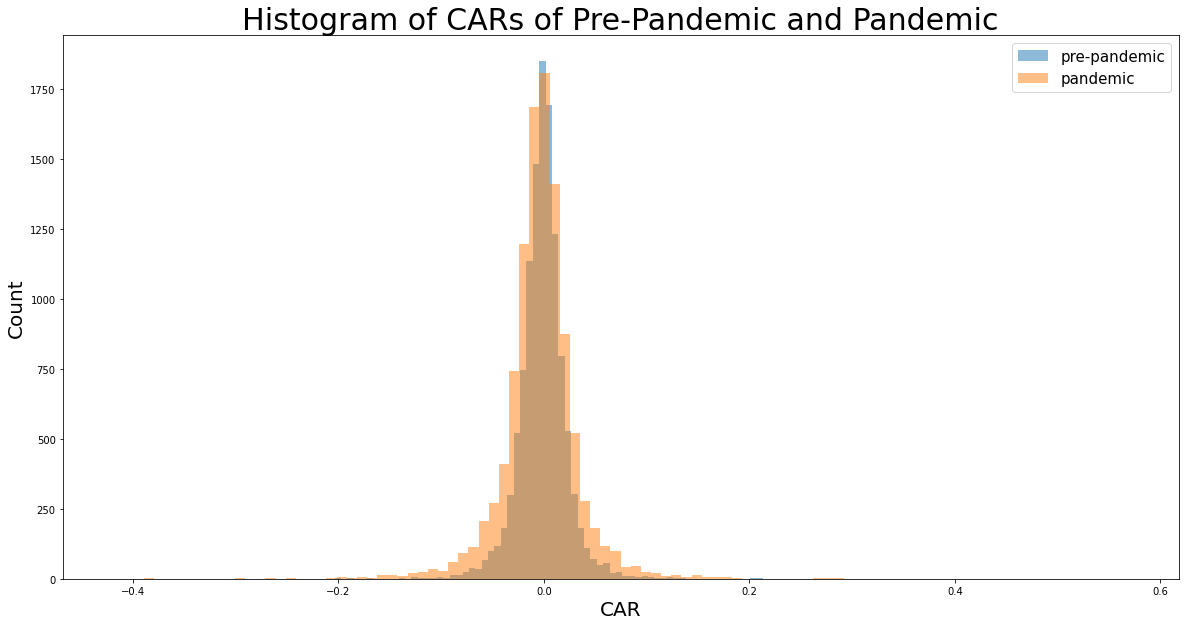

In [41]:
# histograms of simulated means
ttest_results = []
ttest_index = []
from IPython.display import clear_output
for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)

        left, right = investigation_periods["Pre-Pandemic"]
        l_CAR, r_CAR = CAR_periods[cp]

        AR_prepandemic = df_abnormal_returns.loc[:,:,type_,left:right].values

        sample_CAR_prepandemic = AR_prepandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)
        # sample_CAR_prepandemic = R_market_event_window_prepandemic[:,l_CAR:(r_CAR+1)].cumsum(axis=1).mean(axis=0) ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST

        left, right = investigation_periods["Pandemic"]

        AR_pandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = AR_pandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)
        # sample_CAR_pandemic = R_market_event_window_pandemic[:,l_CAR:(r_CAR+1)].cumsum(axis=1).mean(axis=0) ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST
        # import ttest

        ttest = ttest_ind(sample_CAR_pandemic, sample_CAR_prepandemic)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((ttest.pvalue, ttest.statistic))
        ttest_index.append((type_, cp))


        fig = plt.figure(figsize=(fig_height, 10))
        plt.hist(sample_CAR_prepandemic,bins = 100, alpha = 0.5)
        plt.hist(sample_CAR_pandemic,bins = 100, alpha = 0.5)
        plt.legend(["pre-pandemic", "pandemic"], fontsize = tick_size)
        plt.xlabel("CAR", fontsize=label_size)
        plt.ylabel("Count", fontsize=label_size)
        plt.title("Histogram of CARs of Pre-Pandemic and Pandemic", fontsize=title_size)
        plt.savefig(f"data/{NAME}/visualisations/histogram_CARs_pp_p_{type_}_{cp}.svg")

        clear_output(wait=True)
        plt.show()

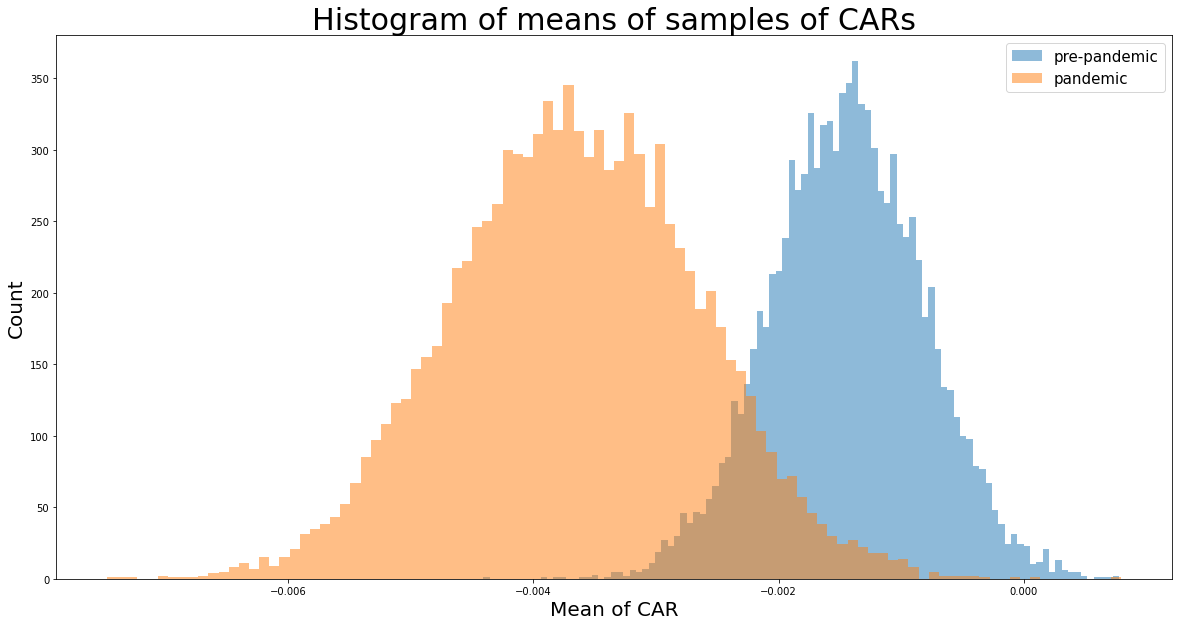

In [62]:
# approach recommended by Aussenegg: Simulate mean differences
ttest_results = []
ttest_index = []
# set np seed
np.random.seed(42)
for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)
        l_CAR, r_CAR = CAR_periods[cp]

        left, right = investigation_periods["Pre-Pandemic"]
        AR_prepandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_prepandemic = AR_prepandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)

        left, right = investigation_periods["Pandemic"]
        AR_pandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = AR_pandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)


        CAAR_pp = sample_CAR_prepandemic.mean()
        CAAR_p = sample_CAR_pandemic.mean()
        CAAR_diff = CAAR_p - CAAR_pp

        sample_size = 1500
        diffs = []
        subsample_means_CAR_prepandemic = []
        subsample_means_CAR_pandemic = []
        for i in range(10000):
            # pick subsample
            subsample_pp = np.random.choice(sample_CAR_prepandemic, sample_size, replace=True)
            subsample_p = np.random.choice(sample_CAR_pandemic, sample_size, replace=True)
            diff = subsample_p-subsample_pp
            subsample_means_CAR_prepandemic.append(subsample_pp.mean())
            subsample_means_CAR_pandemic.append(subsample_p.mean())
            diffs.append(diff.mean())



        fig = plt.figure(figsize=(fig_height, 10))
        plt.hist(subsample_means_CAR_prepandemic,bins = 100, alpha = 0.5)
        plt.hist(subsample_means_CAR_pandemic,bins = 100, alpha = 0.5)
        plt.legend(["pre-pandemic", "pandemic"], fontsize = tick_size)
        plt.xlabel("Mean of CAR", fontsize=label_size)
        plt.ylabel("Count", fontsize=label_size)

        plt.title("Histogram of means of samples of CARs", fontsize=title_size)
        plt.savefig(f"data/{NAME}/visualisations/histogram_mean_CARs_pp_p_{type_}_{cp}.svg")

        clear_output(wait=True)
        plt.show()

        sign = int(2*(bool(CAAR_diff<0) -0.5)) #  check for the correct side of 0.
        p_value = np.mean(sign*np.asarray(diffs) > 0)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((CAAR_diff, p_value))
        ttest_index.append((type_, cp))


In [63]:
ttest_df = pd.DataFrame(ttest_results, index=pd.MultiIndex.from_tuples(ttest_index, names=["Trade Type", "CAR period"]))
ttest_df.columns = ["Δ CAAR", "p-value"]
print(ttest_df.round(10).to_latex())


\begin{tabular}{llrr}
\toprule
            &        &    Δ CAAR &  p-value \\
Trade Type & CAR period &           &          \\
\midrule
P - Purchase & [-20, -1] & -0.043058 &   0.0000 \\
            & [0, 20] & -0.008101 &   0.0864 \\
            & [0, 5] &  0.004211 &   0.1689 \\
            & [0, 1] &  0.004139 &   0.0714 \\
S - Sale & [-20, -1] &  0.005126 &   0.1293 \\
            & [0, 20] & -0.009023 &   0.0265 \\
            & [0, 5] & -0.003718 &   0.0470 \\
            & [0, 1] & -0.001611 &   0.1057 \\
S - Sale+OE & [-20, -1] &  0.002056 &   0.3030 \\
            & [0, 20] & -0.014042 &   0.0002 \\
            & [0, 5] & -0.005634 &   0.0016 \\
            & [0, 1] & -0.002222 &   0.0290 \\
\bottomrule
\end{tabular}



C:\Users\Tom\AppData\Local\Temp\ipykernel_43420\480987785.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ttest_df.round(10).to_latex())


In [44]:
test_results = []
test_index = []

for per in investigation_periods.keys():
    for type_ in types_of_interest:
        for CAR_period_name in CAR_periods.keys():

            print(per)
            print(type_)
            print(CAR_period_name)
            CAR_period = CAR_periods[CAR_period_name]

            left, right = investigation_periods[per]
            AR = df_abnormal_returns.loc[:,:,type_, left:right].values
            eps = df_eps.loc[:,:,type_,left:right].values
            R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
            R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
            grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, False)
            adj_grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
            CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
            test_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            #test_results.append((grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            test_index.append((per, type_, CAR_period_name))

Overall
P - Purchase
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 5]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 1]
Too many events to calculate average cross correlation, subsampling combinations...


KeyboardInterrupt: 

In [ ]:
test_results_df = pd.DataFrame(test_results, index=pd.MultiIndex.from_tuples(test_index, names=["Investigation Period", "Trade Type", "CAR Period"]))
test_results_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adj-GRANK p-value", "adj-GRANK statistic", "adjBMP p-value", "adjBMP t-statistic"]
test_results_df.to_pickle(f"data/{NAME}/statistical_tests/GRANK_ADJBMP.pkl")
test_results_df.to_excel(f"data/{NAME}/statistical_tests/statistical_tests_results.xlsx")
